-----------------------标准化特征---------------------------------
基准模型性能（所有特征）:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        43
           1       0.96      0.97      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

准确率: 0.956140350877193
精确率: 0.9583333333333334
召回率: 0.971830985915493
F1分数: 0.965034965034965
AUC: 0.9908286930887652
MCC: 0.9063785942932301
混淆矩阵:
 [[40  3]
 [ 2 69]]
--------------------------------------------------------
PCA降维后模型性能:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        43
           1       0.99      0.99      0.99        71

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

准确率: 0.9824561403508771
精确率: 0.98

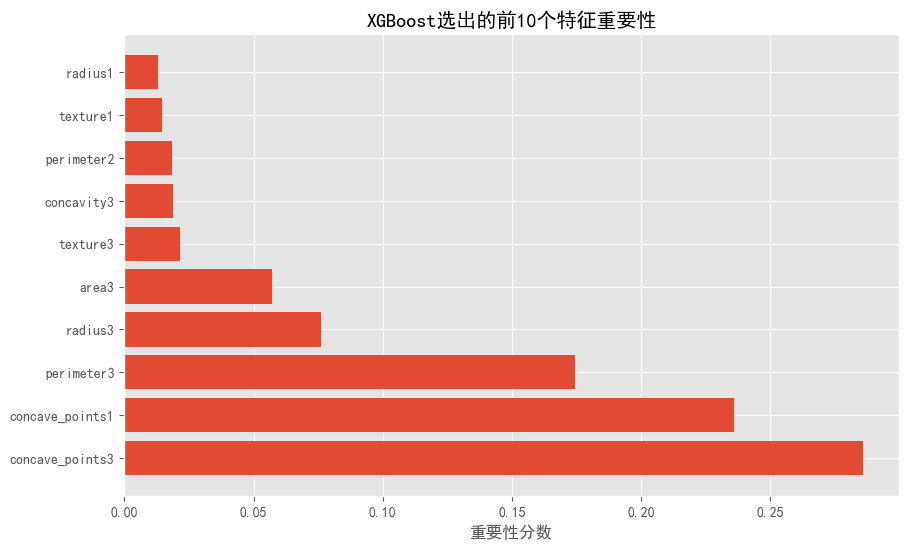

特征选择后模型性能（前10个特征）:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        43
           1       0.96      1.00      0.98        71

    accuracy                           0.97       114
   macro avg       0.98      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

准确率: 0.9736842105263158
精确率: 0.9594594594594594
召回率: 1.0
F1分数: 0.9793103448275862
AUC: 0.9911562397641663
MCC: 0.9447329926514414
混淆矩阵:
 [[40  3]
 [ 0 71]]
--------------------------------------------------------


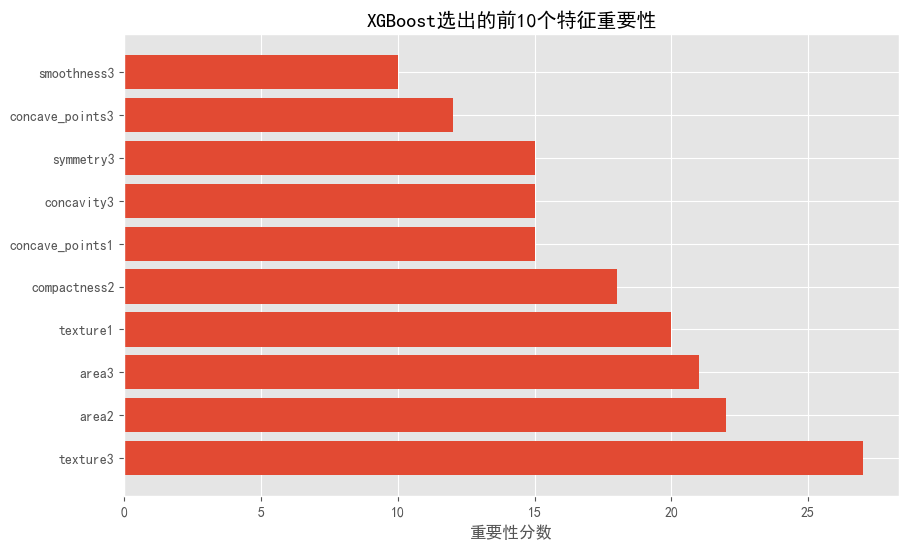

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, confusion_matrix
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use("ggplot")

# 加载数据集
data = pd.read_csv("./breast_cancer_wisconsin_diagnostic.csv")
# 标签转换
data.Diagnosis =[1 if each =="B" else 0 for each in data.Diagnosis]

y = data.Diagnosis.values
X = data.drop(["Diagnosis"], axis=1)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("-----------------------标准化特征---------------------------------")
# 标准化特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# 1. 基准模型（使用所有特征）
baseline_model = XGBClassifier(random_state=42, eval_metric='mlogloss')
baseline_model.fit(X_train_scaled, y_train)
y_pred_baseline = baseline_model.predict(X_test_scaled)
y_proba_baseline = baseline_model.predict_proba(X_test_scaled)[:, 1]

# 评估指标
print("基准模型性能（所有特征）:")
print(classification_report(y_test, y_pred_baseline))
print("准确率:", accuracy_score(y_test, y_pred_baseline))
print("精确率:", precision_score(y_test, y_pred_baseline))
print("召回率:", recall_score(y_test, y_pred_baseline))
print("F1分数:", f1_score(y_test, y_pred_baseline))
print("AUC:", roc_auc_score(y_test, y_proba_baseline))
print("MCC:", matthews_corrcoef(y_test, y_pred_baseline))
print("混淆矩阵:\n", confusion_matrix(y_test, y_pred_baseline))
print("--------------------------------------------------------")

# 2. PCA降维（保留95%的方差）
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

pca_model = XGBClassifier(random_state=42, eval_metric='mlogloss')
pca_model.fit(X_train_pca, y_train)
y_pred_pca = pca_model.predict(X_test_pca)
y_proba_pca = pca_model.predict_proba(X_test_pca)[:, 1]

# 评估指标
print("PCA降维后模型性能:")
print(classification_report(y_test, y_pred_pca))
print("准确率:", accuracy_score(y_test, y_pred_pca))
print("精确率:", precision_score(y_test, y_pred_pca))
print("召回率:", recall_score(y_test, y_pred_pca))
print("F1分数:", f1_score(y_test, y_pred_pca))
print("AUC:", roc_auc_score(y_test, y_proba_pca))
print("MCC:", matthews_corrcoef(y_test, y_pred_pca))
print("混淆矩阵:\n", confusion_matrix(y_test, y_pred_pca))
print("--------------------------------------------------------")

# 3. 特征选择（基于XGBoost的重要性）
# 提取特征重要性
feature_importances = baseline_model.feature_importances_

# 将特征名称映射回原始列名
feature_names = X.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

# 按重要性排序并选择前10个特征
top_features_df = importance_df.sort_values('importance', ascending=False).head(10)
top_features = top_features_df['feature'].values
top_features_importance = top_features_df['importance'].values

# 获取特征索引
top_features_idx = [list(feature_names).index(feature) for feature in top_features]

# 更新训练集和测试集的特征数据
X_train_selected = X_train_scaled[:, top_features_idx]
X_test_selected = X_test_scaled[:, top_features_idx]

selected_model = XGBClassifier(random_state=42, eval_metric='mlogloss')
selected_model.fit(X_train_selected, y_train)
y_pred_selected = selected_model.predict(X_test_selected)
y_proba_selected = selected_model.predict_proba(X_test_selected)[:, 1]

# 评估指标
print("特征选择后模型性能（前10个特征）:")
print(classification_report(y_test, y_pred_selected))
print("准确率:", accuracy_score(y_test, y_pred_selected))
print("精确率:", precision_score(y_test, y_pred_selected))
print("召回率:", recall_score(y_test, y_pred_selected))
print("F1分数:", f1_score(y_test, y_pred_selected))
print("AUC:", roc_auc_score(y_test, y_proba_selected))
print("MCC:", matthews_corrcoef(y_test, y_pred_selected))
print("混淆矩阵:\n", confusion_matrix(y_test, y_pred_selected))
print("--------------------------------------------------------")

# 4. 可视化特征重要性
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_features_importance)
plt.title("XGBoost选出的前10个特征重要性")
plt.xlabel("重要性分数")
plt.show()

#---------------------------------------------------------------
# 3. 特征选择（基于XGBoost的重要性）
# 提取特征重要性
feature_importances = baseline_model.get_booster().get_score(importance_type='weight')

# 将特征名称映射回原始列名
feature_names = X.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': [feature_importances.get(f'f{i}', 0) for i in range(len(feature_names))]
})

# 按重要性排序并选择前10个特征
top_features = importance_df.sort_values('importance', ascending=False).head(10)['feature'].values
top_features_idx = [list(feature_names).index(feature) for feature in top_features]

X_train_selected = X_train_scaled[:, top_features_idx]
X_test_selected = X_test_scaled[:, top_features_idx]

selected_model = XGBClassifier(random_state=42, eval_metric='mlogloss')
selected_model.fit(X_train_selected, y_train)
y_pred_selected = selected_model.predict(X_test_selected)
y_proba_selected = selected_model.predict_proba(X_test_selected)[:, 1]
print("特征选择后模型性能（前10个特征）:")
print(classification_report(y_test, y_pred_selected))
print("准确率:", accuracy_score(y_test, y_pred_selected))
print("精确率:", precision_score(y_test, y_pred_selected))
print("召回率:", recall_score(y_test, y_pred_selected))
print("F1分数:", f1_score(y_test, y_pred_selected))
print("AUC:", roc_auc_score(y_test, y_proba_selected))
print("MCC:", matthews_corrcoef(y_test, y_pred_selected))
print("混淆矩阵:\n", confusion_matrix(y_test, y_pred_selected))
print("--------------------------------------------------------")

# 4. 可视化特征重要性
plt.figure(figsize=(10, 6))
plt.barh(top_features, [feature_importances.get(f'f{i}', 0) for i in top_features_idx])
plt.title("XGBoost选出的前10个特征重要性")
plt.xlabel("重要性分数")
plt.show()



| 方法                     | 准确率          | 精确率          | 召回率          | F1分数          | AUC            | MCC            | 混淆矩阵       |
|--------------------------|-----------------|-----------------|-----------------|-----------------|----------------|----------------|----------------|
| 基准模型（所有特征）     | 0.9561          | 0.9583          | 0.9718          | 0.9650          | 0.9908         | 0.9064         | [[40, 3], [2, 69]] |
| PCA降维（保留95%方差）  | 0.9825          | 0.9859          | 0.9859          | 0.9859          | 0.9941         | 0.9627         | [[42, 1], [1, 70]] |
| 特征选择（`feature_importances_`） | 0.9561          | 0.9583          | 0.9718          | 0.9650          | 0.9895         | 0.9064         | [[40, 3], [2, 69]] |
| 特征选择（`get_booster().get_score()`） | 0.9737          | 0.9595          | 1.0000          | 0.9793          | 0.9912         | 0.9447         | [[40, 3], [0, 71]] |

